# Intensity predictions
Thin film XRD intensity was modelled without a monochromator. And this *almost* made it into the paper! — but we caught our monochromator.

See `XRD_intensity_simulator` for our up-to-date model, considering the 2-bounce Ge (220) monochromator used.

Note this ipynb will not run as is; the following cells must be appended at the "intensity predictions" section in `XRD_intensity_simulator`.

## Thin film XRD intensity without monochromator

$$I_{hkl}=\frac{{1+\cos(2\theta)^{2}}}{\sin(\theta)\cos(\theta)}\cdot |S_{hkl}|^{2}$$
Modifications to powder XRD:
- the multiplicity factor is now uniformly 1 for all hkl
- the polarization factor stays
- the thin film Lorentz factor is $\frac{1}{\sin(\theta)\cos(\theta)}$

In [1]:
'''
 intensity of the peak hkl when La distribution described by x
 @param hkl string
 @param x float
 @param M dict
 @param S(hkl,x)
'''
def thin_I(hkl,abc,x,S):
    return lorentz(hkl,abc) * sintheta(abc,hkl) *  (np.absolute(S(hkl, x)) ** 2)

In [27]:
'''
La2p3TiO3 intensity shortcut. Increase robustness, decrease mem efficiency.
- using lorentz v1.
@param s input order param directly
'''
def LaI(hkl,s):
    return thin_I(hkl,LTO_abc,x_from_sigma(s),L2p3TO_S)

In [29]:
'''
Finds intersection of an intensity ratio function with a horizontal line. Oh, it also plots the curve and point of intersection in a colour you like.
@param target_y The horizontal line.
@param x_coords
@param y_coords
@param color Matplotlib color character.
'''
def plot_with_intersection(target_y,x_coords,y_coords,color):
    hline = target_y * np.ones(len(y_coords))
    idx = np.argwhere(np.diff(np.sign(y_coords-hline)))[0,0]

    plt.plot(x_coords,y_coords,color)
    plt.plot(x_coords[idx],y_coords[idx],color+'o',label='{:.2f}'.format(x_coords[idx]))
    plt.legend()
    print(f'Order parameter ','{:.2f}'.format(x_coords[idx]))
    return x_coords[idx]


In [37]:
def fig6a(s1, s2, b1, b2, b3, b4):
    s = np.linspace(0,1,100)

    avg_op = np.mean((
    plot_with_intersection(
        s1/b2,
        s,
        LaI('001',s)
        /(LaI('004',s)
        +LaI('200',s)
        +LaI('020',s)
        ),
        'b'
    ),

    plot_with_intersection(
        s1/b4,
        s,
        LaI('001',s)
        /(LaI('008',s)
        +LaI('400',s)
        +LaI('040',s)
        ),
        'r'
    ),

    plot_with_intersection(
        s1/b3,
        s,
        LaI('001',s)
        /(LaI('006',s)
        +LaI('300',s)
        +LaI('030',s)
        ),
        'c'
    ),

    plot_with_intersection(
        s1/b1,
        s,
        LaI('001',s)
        /(LaI('002',s)
        +LaI('100',s)
        +LaI('010',s)
        ),
        'k'
    ),
    ))
    # plt.axvline(avg_op)
    plt.axvline(0.42)
    plt.axvline(0.56,ls=":")
    plt.axvline(0.28,ls=":")
    plt.rcParams.update({'font.size': 14})

    plt.savefig('/Users/beep/Desktop/La2-3/La2-3_Fig6_small1.svg')

    plt.show()

    avg_op2 = np.mean((
    plot_with_intersection(
        s2/b2,
        s,
        LaI('003',s)
        /(LaI('004',s)
        +LaI('200',s)
        +LaI('020',s)
        ),
        'b'
    ),

    plot_with_intersection(
        s2/b4,
        s,
        LaI('003',s)
        /(LaI('008',s)
        +LaI('400',s)
        +LaI('040',s)
        ),
        'r'
    ),

    plot_with_intersection(
        s2/b3,
        s,
        LaI('003',s)
        /(LaI('006',s)
        +LaI('300',s)
        +LaI('030',s)
        ),
        'c'
    ),

    plot_with_intersection(
        s2/b1,
        s,
        LaI('003',s)
        /(LaI('002',s)
        +LaI('100',s)
        +LaI('010',s)
        ),
        'k'
    ),
    ))
    plt.axvline(0.42)
    plt.axvline(0.56,ls=":")
    plt.axvline(0.28,ls=":")
    plt.rcParams.update({'font.size': 14})
    plt.savefig('/Users/beep/Desktop/La2-3/La2-3_Fig6_small2.svg')

    return avg_op, avg_op2


Order parameter  0.42
Order parameter  0.66
Order parameter  0.53
Order parameter  0.25


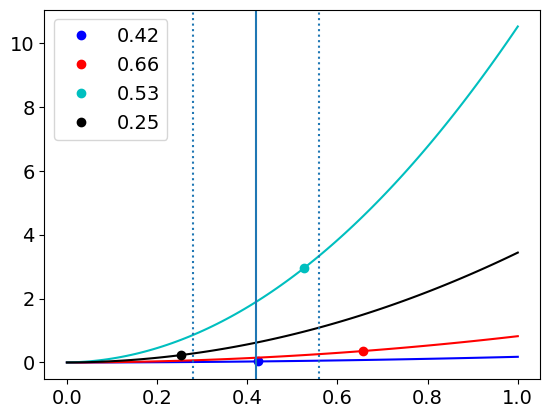

Order parameter  0.34
Order parameter  0.53
Order parameter  0.42
Order parameter  0.21


(0.4646464646464647, 0.3762626262626263)

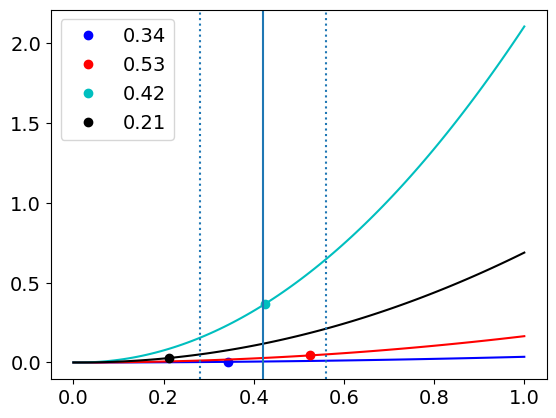

In [40]:
# p = 0.62
fig6a(8.67,1.09,35.76,261.77,2.91,23.76)

In [42]:
np.std((
0.42,
0.66,
0.53,
0.25,
0.34,
0.53,
0.42,
0.21,
))

0.14195069566578392

In [41]:
np.mean((0.4646464646464647, 0.3762626262626263))

0.4204545454545455